<a href="https://colab.research.google.com/github/selvataas/Patika_NewMind_AI_Final_Task/blob/master/Summarization_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers[sentencepiece]

In [6]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import re

from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics import classification_report, balanced_accuracy_score
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import ConfusionMatrixDisplay

## Import HF pipeline for zero-shot-classification

Zero shot classification için uygun, çok dilli bir veri kümesi üzerinde eğitilmiş bir NLI modeli (https://nlpprogress.com/english/natural_language_inference.html) kullanacağım.

In [13]:
first_time_right = pipeline("zero-shot-classification", model='MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

- NLI modelleri, bir öncül (premise) ve bir hipotez (hypothesis) kullanılarak eğitildiği için, bir metin dizisini öncül olarak kullanırız ve olası etiketlerin bir setini hipotezler olarak belirleriz. Aşağıdaki örnekte, bir ifade (öncül) sağlıyoruz ve tüm olası etiketlerle bir hipotez şablonu kullanıyoruz. Model, her etiket için bir olasılık sağlayacaktır. Eğer multi_label parametresi False olarak ayarlanırsa, tüm olasılıkların toplamı 1 olacaktır.

- first_time_right: zero-shot-classification görevini gerçekleştirecek olan pipeline nesnesini temsil eder. Bu değişkenin adı, kodun yazarı tarafından anlamlı bir şekilde seçilmiştir, yani modelin "ilk seferde doğru" sonuçlar üretmesini beklediği anlamına gelir

In [14]:
sequence = "A walk during your lunch break is an excellent way to keep you a vital employee."
candidate_labels = ["politics", "family", "health", "work"]
hypothesis_template = "This statement is about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=False)

In [15]:
def format_pred(input):
  print(f"Premise \t{input['sequence']}")
  print(f"Hypothesis \t{hypothesis_template[:-3]}:")
  for label, score in zip(input['labels'], input['scores']):
   print((f" - {label}:\t {score:.2f}").expandtabs(40))

format_pred(output)

Premise 	A walk during your lunch break is an excellent way to keep you a vital employee.
Hypothesis 	This statement is about:
 - health:                               0.65
 - work:                                 0.34
 - family:                               0.00
 - politics:                             0.00


In [16]:
sequence = "Une promenade pendant votre pause déjeuner est un excellent moyen de maintenir votre vitalité en tant qu'employé."
candidate_labels = ["politics", "family", "health", "work"]
hypothesis_template = "This statement is about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=False)
format_pred(output)

Premise 	Une promenade pendant votre pause déjeuner est un excellent moyen de maintenir votre vitalité en tant qu'employé.
Hypothesis 	This statement is about:
 - health:                               0.55
 - work:                                 0.45
 - family:                               0.00
 - politics:                             0.00


**Ancak, modele verilen metin (öncül, hipotez, etiketler), modelin eğitildiği veri kümesine benzemezse, model zorlanacaktır. Daha az kullanılan ifadeler, tokenizer sözlüğünde bulunmayabilir ve bu durum etiketler arasında ayrım yapmayı zorlaştırır.**

- Bu örnek için, US Consumer Complaints Database’den 10,000 müşteri şikayeti verisi aldım. Orijinal veri setinde yazılı şikayetler, bir ürün etiketi ve 20 diğer özellik bulunmaktadır. Burada yalnızca atanan İssue_label ve complaint metni kullandım.

```
# Bu, kod olarak biçimlendirilmiştir
```



In [18]:
df = pd.read_csv('/content/drive/MyDrive/FINAL_PROJECT/account_complaints_cleaned.csv', delimiter="|", on_bad_lines='skip')
df.head()

,issue_label,complaint
0,Closing an account,I just today received a notification from PNC ...
1,Transaction was not authorized,"On XX/XX/XXXX, a series of fraudulent charges ..."
2,Closing an account,"Dear Sir/Madam, On XX/XX/XXXX, BOA froze my ch..."
3,Transaction was not authorized,In the month of XXXX I became a victim of frau...
4,Closing an account,XX/XX/21 us bank XXXX XXXX XXXX branch manager...


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9903 entries, 0 to 9902
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issue_label  9903 non-null   object
 1   complaint    9903 non-null   object
dtypes: object(2)
memory usage: 154.9+ KB


In [20]:
df.isnull().sum()

,0
issue_label,0
complaint,0


# Text Pre-processing

In [21]:
df.iloc[4,1]

'XX/XX/21 us bank XXXX XXXX XXXX branch manager of XXXX XXXX night I had stopped by US banks ATM machine and attempted to deposit cash into my bank account. After deposit the ATM machine did not credit my account nor give me back my cash. Instead it issued receipt and told me to call a number in regards to my issues. Upon calling said number I reached XXXX branch manager of store XXXX. XXXX was Extremely unhelpful he was bias from the start of the call. He wouldnt listen to my complaints and concerns he showed no compassion nor degree of wanting to solve the problem at hand. He argued with me and I had a number of times threaten to close my account at which times I would remind him that you can not be in your personal bias and then get mad at the customer for letting me see how you came out of your professionalism and now letting your personal hangups dictate the way you were. There was no reason for him to threaten to close my account I simply needed him to do his job and help me out.

In [22]:
def clean_text(input):
        input = re.sub("\(.*?\)|\{.*?\}", ' ', input) # remove content between {}
        input = re.sub('XXXX', ' ', input) # remove masked names  and years
        input = re.sub('XX/XX/', ' ', input) # remove masked date parts
        input = re.sub('<.*?>', ' ', input) #remove HTML code
        input = re.sub('\n+', ' ', input)  # remove newline chars
        input = re.sub('[0-9]+', ' ', input) # remove numbers
        input = re.sub(" EUR", ' ', input) # remove EUR remainders
        input = re.sub('  ', '', input) # double spaces
        return(input)

In [23]:
clean_text(df.iloc[4,1])

' us bank branch manager of night I had stopped by US banks ATM machine and attempted to deposit cash into my bank account. After deposit the ATM machine did not credit my account nor give me back my cash. Instead it issued receipt and told me to call a number in regards to my issues. Upon calling said number I reached branch manager of store. was Extremely unhelpful he was bias from the start of the call. He wouldnt listen to my complaints and concerns he showed no compassion nor degree of wanting to solve the problem at hand. He argued with me and I had a number of times threaten to close my account at which times I would remind him that you can not be in your personal bias and then get mad at the customer for letting me see how you came out of your professionalism and now letting your personal hangups dictate the way you were. There was no reason for him to threaten to close my account I simply needed him to do his job and help me out.He wanted to argue and did so with me for over a

In [24]:
df['complaint_cleaned'] = df['complaint'].apply(clean_text)

In [25]:
df.head()

,issue_label,complaint,complaint_cleaned
0,Closing an account,I just today received a notification from PNC ...,I just today received a notification from PNC ...
1,Transaction was not authorized,"On XX/XX/XXXX, a series of fraudulent charges ...","On , a series of fraudulent charges hit my Cap..."
2,Closing an account,"Dear Sir/Madam, On XX/XX/XXXX, BOA froze my ch...","Dear Sir/Madam, On , BOA froze my checking acc..."
3,Transaction was not authorized,In the month of XXXX I became a victim of frau...,In the month of I became a victim of fraudulen...
4,Closing an account,XX/XX/21 us bank XXXX XXXX XXXX branch manager...,us bank branch manager of night I had stopped...


Şikayetlerle ilgili olarak bankanın daha önceden sağladığı etiketlere bakıyoruz. Bu seçenekte dört farklı türde şikayet bulunmaktadır:

- Bir para yatırma veya çekme işlemiyle ilgili bir şikayet,
- Yetkisiz bir işlem gerçekleşti,
- Hesap kapatma ile ilgili bir şikayet,
- Hesaba erişim sağlama yeteneğiyle ilgili bir şikayet.

In [26]:
df['issue_label'].unique()

array(['Closing an account', 'Transaction was not authorized',
       'Problem accessing account', 'Deposits and withdrawals'],
      dtype=object)

Aşağıdaki etiketler, okunabilir bir hipotezi yansıtacak şekilde biraz değiştirilmiştir. Bu şekilde, şikayetin metni öncül olarak kullanılır ve hipotez şu şekilde oluşturulur:
- "Bu, hesabın kapatılmasıyla ilgili bir müşteri şikayetidir."

Bu şikayetlerin birden fazla doğru etikete sahip olması mümkün olabilir. Bir şikayet hem bir para çekme işlemiyle hem de yetkisiz bir işlemle ilgili olabilir. Bu nedenle çoklu etiketli bir çıktı kullanacağız.

In [27]:
sequence = df.iloc[2,2]
candidate_labels = ['closing the account', 'online login to account', 'a deposit or withdrawal', 'an unauthorized transaction']
hypothesis_template = "This is a customer complaint about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
format_pred(output)

Premise 	Dear Sir/Madam, On , BOA froze my checking account ending in. I reached out to the BOA and found out that it was a business decision they took to freeze my account but they wouldn't close the account and release my money till the issue with my other checking account ending in is closed. Basically keeping my money in the account.Regarding, we suspected fraud activity on this account onand the account has been in the credit only state since then i.e. . The balance in that account was before it went into credit only state. Now the balance is cents due to all the BOA holding fees. But BOA is not able to close this account due to fraud transactions always in the pending/processing status. I have spoken to Fraud dept multiple times in last months, they just not able to block these fraud ACH transactions but told me not to worry about it as the account is in credit only state, the transactions wouldnt post but they wouldnt be able to close this account with transactions pending.I hav

**Model, temizlenmiş müşteri şikayetlerini verilen aday etiketlere göre sınıflandırarak, her bir şikayet için en olası etiketleri ve olasılıklarını döndürüyor.**

In [28]:
df_test = df.sample(100).reset_index(drop=True)  # İndeks sıfırlandım

def classify_all_complaints(df, candidate_labels, hypothesis_template):

    for i in tqdm(range(0, df.shape[0])):
        complaint = df.loc[i, 'complaint_cleaned']
        if complaint is not None:
            pd.options.mode.chained_assignment = None
            result = first_time_right(complaint, candidate_labels=candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)

            df.loc[i, 'label_1'] = result['labels'][0]
            df.loc[i, 'score_1'] = result['scores'][0]
            df.loc[i, 'label_2'] = result['labels'][1]
            df.loc[i, 'score_2'] = result['scores'][1]
            df.loc[i, 'label_3'] = result['labels'][2]
            df.loc[i, 'score_3'] = result['scores'][2]

    print("Processed DataFrame Sample:")
    print(df.head())

    return df

# df_test = classify_all_complaints(df_test, candidate_labels=["label_1", "label_2", "label_3"], hypothesis_template="This complaint is about {}.")

In [29]:
df_test = classify_all_complaints(df_test.drop('complaint', axis=1), candidate_labels, hypothesis_template)

100%|██████████| 100/100 [37:27<00:00, 22.48s/it]

Processed DataFrame Sample:
                      issue_label  \
0              Closing an account   
1        Deposits and withdrawals   
2  Transaction was not authorized   
3        Deposits and withdrawals   
4              Closing an account   

                                   complaint_cleaned  \
0  Citibank has restricted my account since of th...   
1  Over the past-months. I have had several finan...   
2  I had charges on the same morning from a websi...   
3  I disputed charges by for the canceled flight,...   
4  This complaint relates to complaint already fi...   

                       label_1   score_1                      label_2  \
0          closing the account  0.999634      online login to account   
1  an unauthorized transaction  0.062227      a deposit or withdrawal   
2  an unauthorized transaction  0.999778      online login to account   
3  an unauthorized transaction  0.997911      online login to account   
4          closing the account  0.997006  an un

In [30]:
rename = {'closing the account': 'Closing an account' ,
          'online login to account': 'Problem accessing account'
          , 'a deposit or withdrawal': 'Deposits and withdrawals'
          , 'an unauthorized transaction': 'Transaction was not authorized'
          }

df_test['pred_label'] = df_test['label_1'].map(rename)

In [31]:
df_test

,issue_label,complaint_cleaned,label_1,score_1,label_2,score_2,label_3,score_3,pred_label
0,Closing an account,Citibank has restricted my account since of th...,closing the account,0.999634,online login to account,0.286590,an unauthorized transaction,0.080693,Closing an account
1,Deposits and withdrawals,Over the past-months. I have had several finan...,an unauthorized transaction,0.062227,a deposit or withdrawal,0.025004,online login to account,0.000281,Transaction was not authorized
2,Transaction was not authorized,I had charges on the same morning from a websi...,an unauthorized transaction,0.999778,online login to account,0.001173,a deposit or withdrawal,0.000532,Transaction was not authorized
3,Deposits and withdrawals,"I disputed charges by for the canceled flight,...",an unauthorized transaction,0.997911,online login to account,0.048396,a deposit or withdrawal,0.004689,Transaction was not authorized
4,Closing an account,This complaint relates to complaint already fi...,closing the account,0.997006,an unauthorized transaction,0.996423,a deposit or withdrawal,0.000117,Closing an account
...,...,...,...,...,...,...,...,...,...
95,Deposits and withdrawals,I would like to make a complaint against Chime...,a deposit or withdrawal,0.559510,an unauthorized transaction,0.528446,online login to account,0.007254,Deposits and withdrawals
96,Deposits and withdrawals,I made a check deposit into my bmo account. Th...,a deposit or withdrawal,0.999697,an unauthorized transaction,0.998237,closing the account,0.002084,Deposits and withdrawals
97,Deposits and withdrawals,We received a letter from M & T bank postmarke...,closing the account,0.998597,an unauthorized transaction,0.000251,online login to account,0.000137,Closing an account
98,Closing an account,I had a checking account with Hancock Whitney ...,an unauthorized transaction,0.999708,closing the account,0.994972,online login to account,0.065266,Transaction was not authorized


In [32]:
true_label = np.array(df_test['issue_label'])
pred_label = np.array(df_test['pred_label'])
clf = classification_report(true_label, pred_label, zero_division=0, output_dict=True)

In [33]:
clf['weighted avg']

{'precision': 0.6444795321637428,
 'recall': 0.6,
 'f1-score': 0.5798796356538712,
 'support': 100.0}

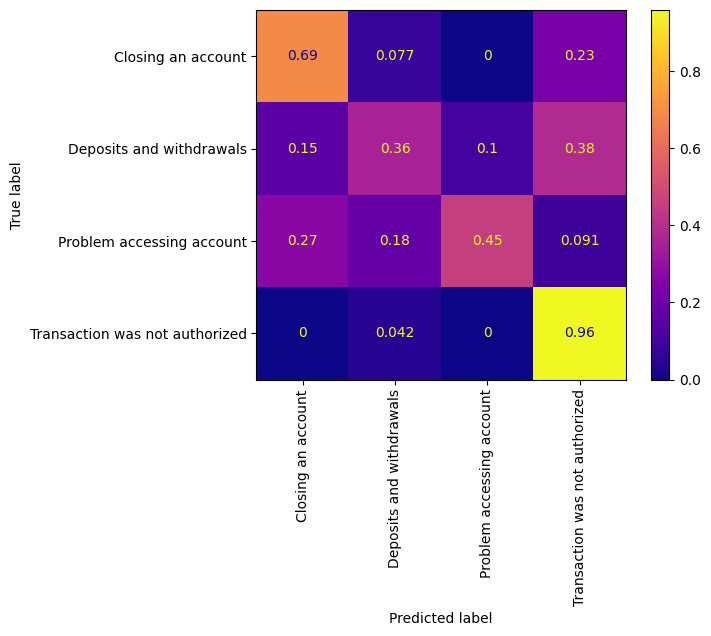

In [34]:
ConfusionMatrixDisplay.from_predictions(true_label, pred_label, normalize='true', xticks_rotation='vertical', cmap='plasma')

In [36]:
# from google.colab import files
# df_test.to_csv('df_test.csv', encoding = 'utf-8-sig')
# files.download('df_test.csv')

In [37]:
# df_test.to_csv('classified_complaints1.csv', index=False)

# Conclusion with LLM¶

In [ ]:
!pip install sentence-transformers scikit-learn

In [69]:
df_test.iloc[6,1]

'I am a former Wells Fargo customer. I closed my accounts with them several years ago. I still receive bill pay reminder notices and updates to online banking account terms and conditions. I have called and they assure me it is taken care of. Then I receive another notice.I would like the emails to stop. If Wells thinks I am still a customer, somewhere in their systems my profile is still active. This presents an opportunity for fraud!'

In [70]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")
llm = pipeline("text2text-generation", model="facebook/bart-large")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

text = input("Lütfen şikayet metnini girin: ")

candidate_labels = [
    'closing the account',
    'online login to account',
    'a deposit or withdrawal',
    'an unauthorized transaction'
]


classification = classifier(text, candidate_labels=candidate_labels, multi_label=False)
predicted_label = classification["labels"][0]


input_text = (f"Summarize the following complaint text meaningfully with more context and details: '{text}'")

expanded_text = llm(
    input_text,
    max_length=250,
    repetition_penalty=2.0,
    num_return_sequences=1,
    truncation=True
)[0]["generated_text"]

Lütfen şikayet metnini girin: I am a former Wells Fargo customer. I closed my accounts with them several years ago. I still receive bill pay reminder notices and updates to online banking account terms and conditions. I have called and they assure me it is taken care of. Then I receive another notice.I would like the emails to stop. If Wells thinks I am still a customer, somewhere in their systems my profile is still active. This presents an opportunity for fraud!


In [71]:
print("\nTahmin Edilen Şikayet Kategorisi:")
print(predicted_label)

print("\nÖzetlenmiş Metin:")
print(expanded_text)


Tahmin Edilen Şikayet Kategorisi:
closing the account

Özetlenmiş Metin:
Summarize the following complaint text meaningfully with more context and details: 'I am a former Wells Fargo customer. I closed my accounts with them several years ago. I still receive bill pay reminder notices and updates to online banking account terms and conditions. I have called and they assure me it is taken care of. Then I receive another notice.I would like the emails to stop. If Wells thinks I am still a customer, somewhere in their systems my profile is still active. This presents an opportunity for fraud!'


In [72]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

original_text = text
summary_text = expanded_text

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

original_vec = model.encode([original_text])
summary_vec = model.encode([summary_text])

similarity_score = cosine_similarity(original_vec, summary_vec)[0][0]
print(f"Semantik Benzerlik Skoru: {similarity_score}")

Semantik Benzerlik Skoru: 0.9404159784317017


In [73]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")
llm = pipeline("text2text-generation", model="t5-base")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

text = input("Lütfen şikayet metnini girin: ")

candidate_labels = [
    'closing the account',
    'online login to account',
    'a deposit or withdrawal',
    'an unauthorized transaction'
]

classification = classifier(text, candidate_labels=candidate_labels, multi_label=False)
predicted_label = classification["labels"][0]

input_text = (f"Summarize the following complaint text meaningfully with more context and details: '{text}'")

expanded_text = llm(
    input_text,
    max_length=250,
    repetition_penalty=2.0,
    num_return_sequences=1,
    truncation=True
)[0]["generated_text"]

Lütfen şikayet metnini girin: I am a former Wells Fargo customer. I closed my accounts with them several years ago. I still receive bill pay reminder notices and updates to online banking account terms and conditions. I have called and they assure me it is taken care of. Then I receive another notice.I would like the emails to stop. If Wells thinks I am still a customer, somewhere in their systems my profile is still active. This presents an opportunity for fraud!


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [74]:
print("\nTahmin Edilen Şikayet Kategorisi:")
print(predicted_label)

print("\nÖzetlenmiş Metin:")
print(expanded_text)


Tahmin Edilen Şikayet Kategorisi:
closing the account

Özetlenmiş Metin:
'I am still receiving bill pay reminder notices and updates to online banking account terms and conditions. I have called and they assure me it is taken care of. Then again, the emails are sent to my inbox. If Well Fargo think that you are still a customer, somewhere within their systems your profile has been active. This presents an opportunity for fraud!'


In [75]:
original_text = text
summary_text = expanded_text

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

original_vec = model.encode([original_text])
summary_vec = model.encode([summary_text])

similarity_score = cosine_similarity(original_vec, summary_vec)[0][0]
print(f"Semantik Benzerlik Skoru: {similarity_score}")

Semantik Benzerlik Skoru: 0.800458550453186
